## Basic analysis of tracking data from CsChrimson experiments in free walking arena

#### Note: This script should be used for data collected using the a stimulation protocol generated by optogeneticsProtocol_quadrantAssay_round2.py (quadrant stimulation before 5s full-field continuous stimulation)

In [1]:
from scipy.io import loadmat
from csv import reader
import matplotlib.colors as colors
import numpy as np
import seaborn as sns
from scipy import sparse as sps
from os import mkdir

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec

%matplotlib inline

### Set experiment parameter

In [21]:
baseDir = '/Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/\
20xCsChrWTB_x_cupcake_female_RetinalInWuerzburg/group/LED10/'
#fileName = '20xCsChr_x_HC-Gal4_female_1LEDpower_repeat1_cam_0_date_2015_09_20_time_15_05_46_v001.mat'

analysisDir = baseDir

fps = 30 # Video sampling rate
imageSizePx = (1280,1024) #(1008,1000) #size of the recorded frames in pixel

##### Load file list and first frame numbers

In [22]:
expListFile = baseDir + 'firstFrames.csv'
print('Reading in stimulation start frame list from ' + expListFile)

# load file specifying data to be analysed
fileList = open(expListFile, 'r')
csv_fileList = reader(fileList)

# get header
header = fileList.readline().split(',')

fileNames = []
startFrames = []

for line in csv_fileList:
    fileNames.append(line[1])
    startFrames.append(line[2])

Reading in stimulation start frame list from /Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/20xCsChrWTB_x_cupcake_female_RetinalInWuerzburg/group/LED10/firstFrames.csv


In [23]:
fileNames

['20xCsChrWTB_x_cupcake-Gal4_female_RetinalInWuerzburg_10LEDpower_repeat6_cam_0_date_2016_05_24_time_23_44_04_v001',
 '20xCsChrWTB_x_cupcake-Gal4_female_RetinalInWuerzburg_10LEDpower_repeat5_cam_0_date_2016_05_19_time_21_25_34_v001',
 '20xCsChrWTB_x_cupcake-Gal4_female_RetinalInWuerzburg_10LEDpower_repeat3_cam_0_date_2016_04_28_time_19_44_36_v001',
 '20xCsChrWTB_x_cupcake-Gal4_female_RetinalInWuerzburg_10LEDpower_repeat1_cam_0_date_2016_04_22_time_18_56_26_v001',
 '20xCsChrWTB_x_cupcake-Gal4_female_RetinalInWuerzburg_10LEDpower_repeat4_cam_0_date_2016_05_18_time_18_17_55_v001',
 '20xCsChrWTB_x_cupcake-Gal4_female_RetinalInWuerzburg_10LEDpower_repeat2_cam_0_date_2016_04_22_time_19_05_05_v001']

20xCsChrWTB_x_cupcake-Gal4_female_RetinalInWuerzburg
10LEDpower_repeat6
20xCsChrWTB_x_cupcake-Gal4_female_RetinalInWuerzburg
10LEDpower_repeat5
20xCsChrWTB_x_cupcake-Gal4_female_RetinalInWuerzburg
10LEDpower_repeat3
20xCsChrWTB_x_cupcake-Gal4_female_RetinalInWuerzburg
10LEDpower_repeat1
20xCsChrWTB_x_cupcake-Gal4_female_RetinalInWuerzburg
10LEDpower_repeat4


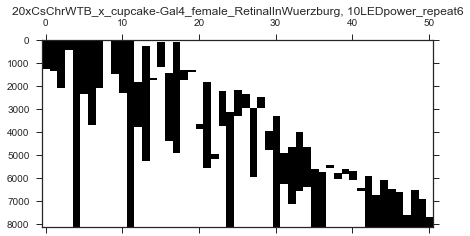

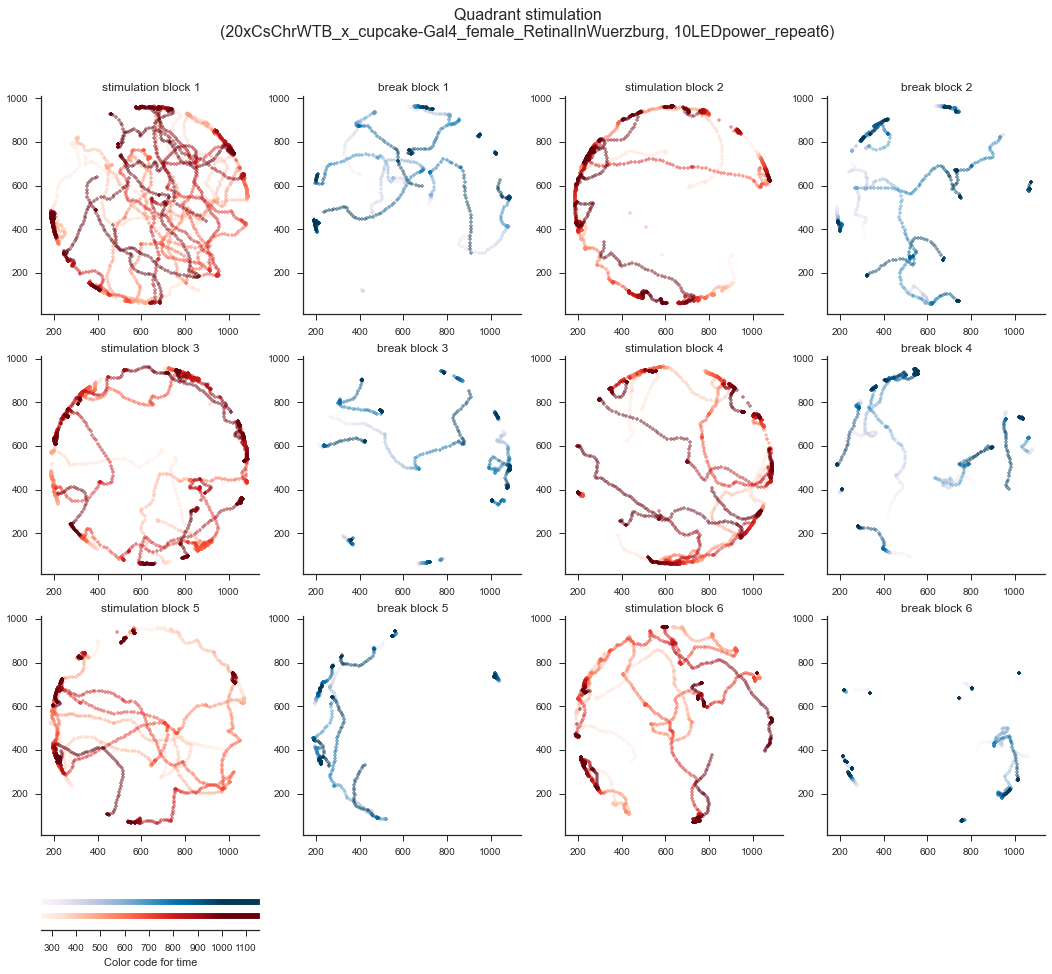

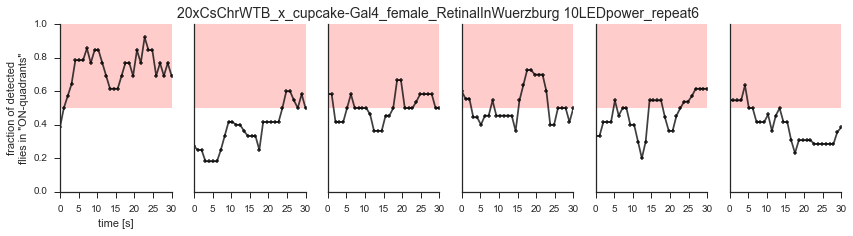

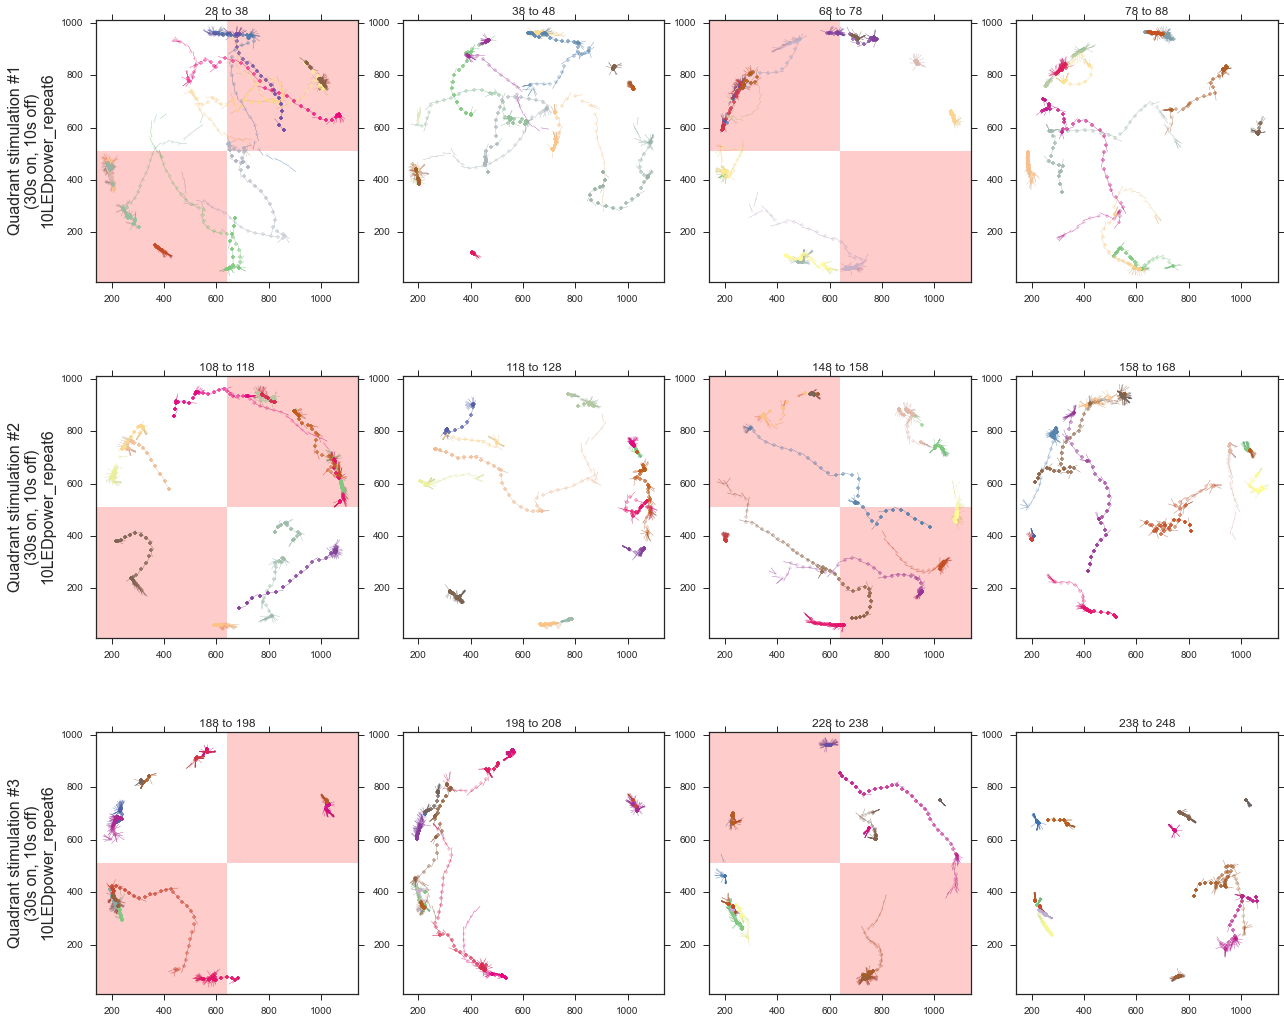

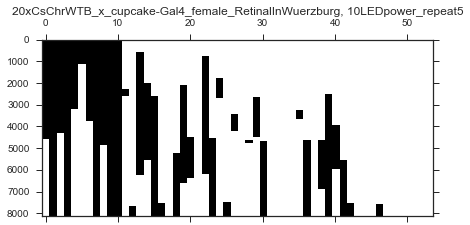

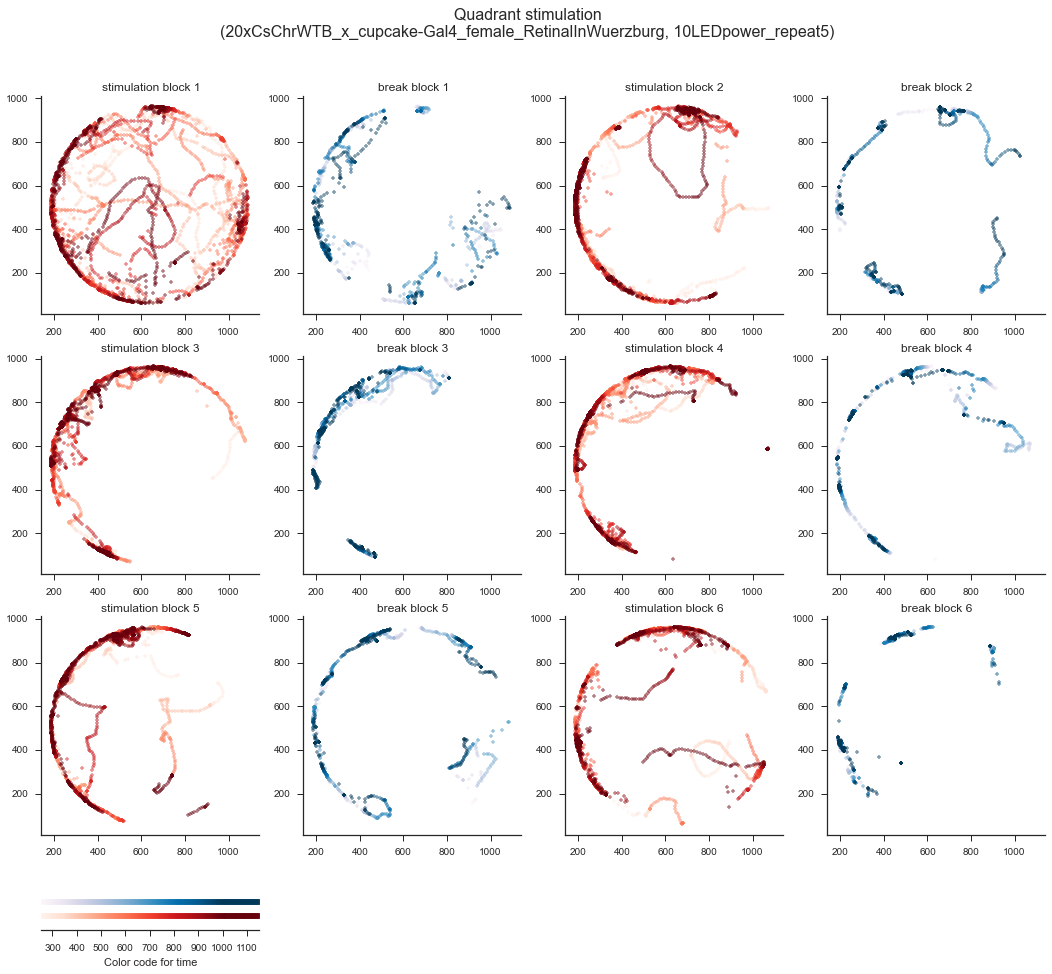

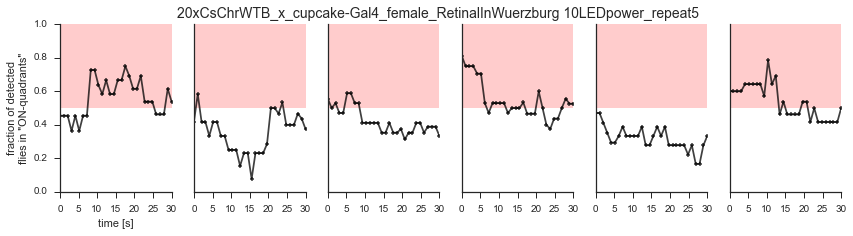

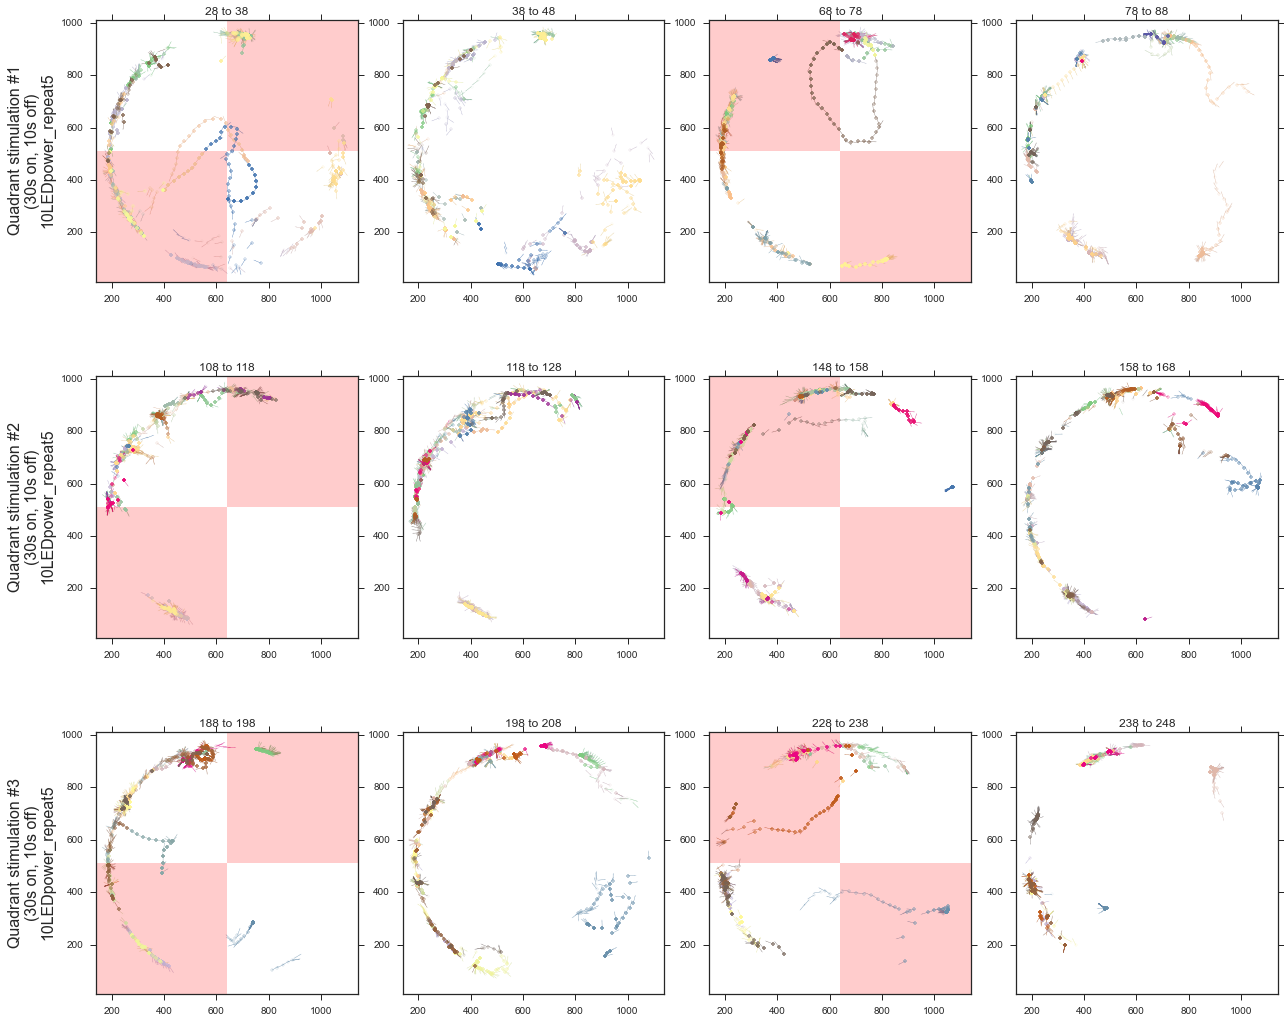

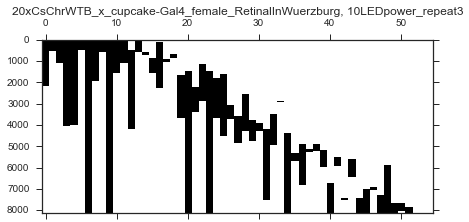

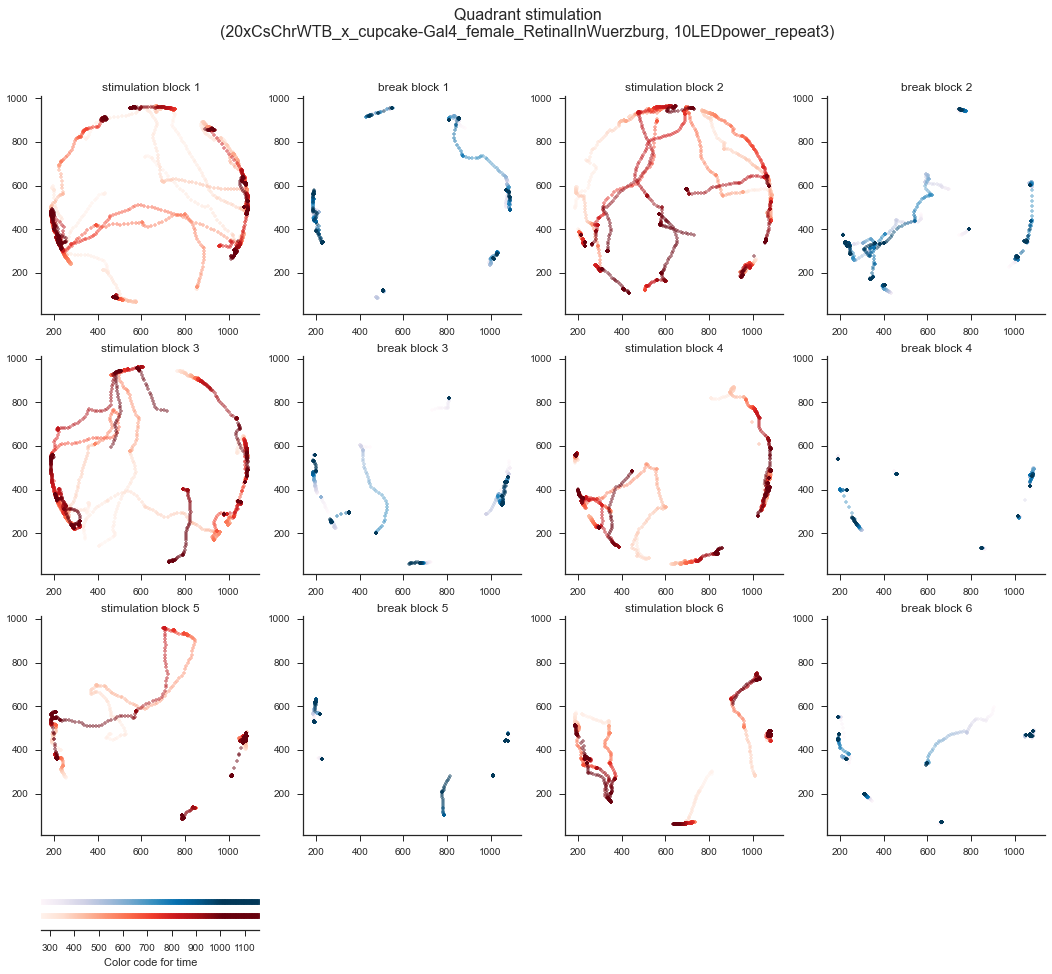

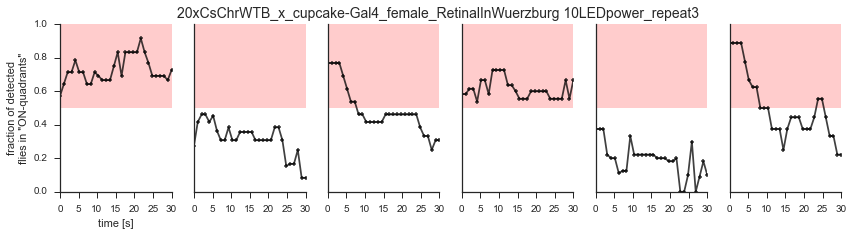

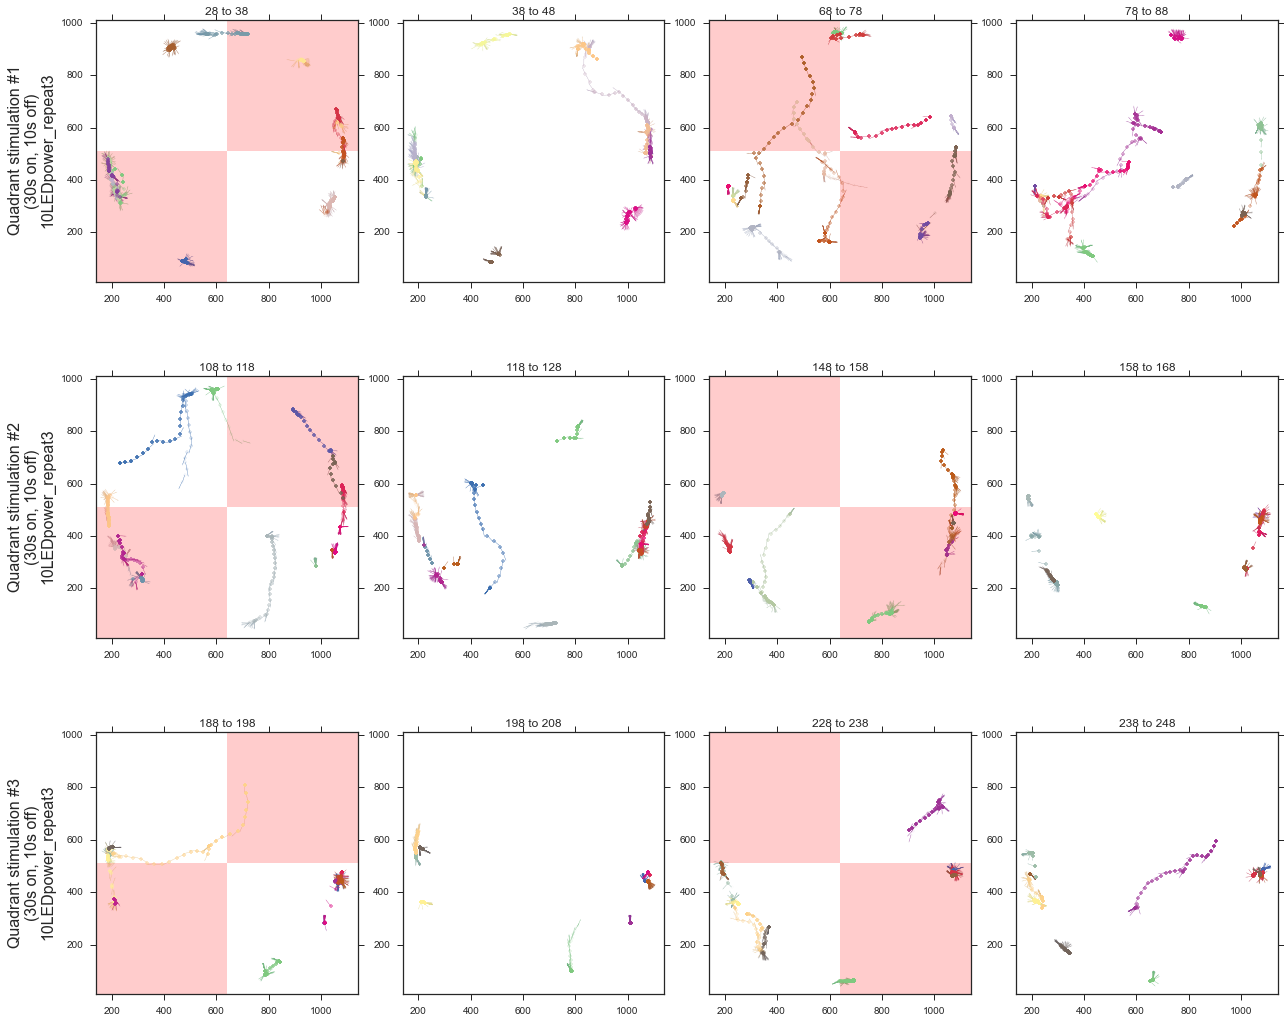

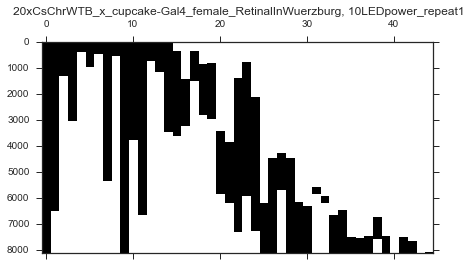

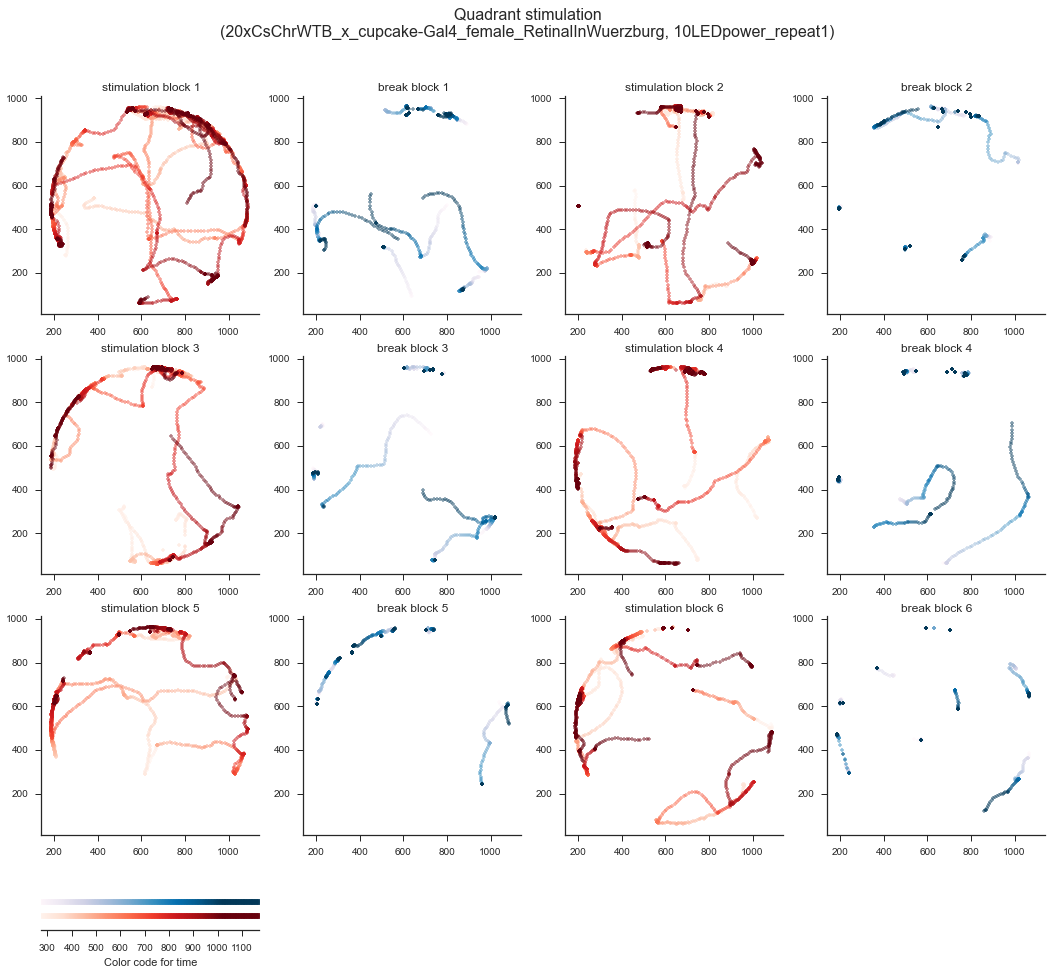

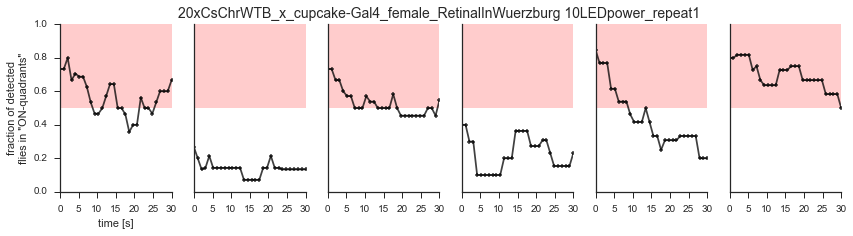

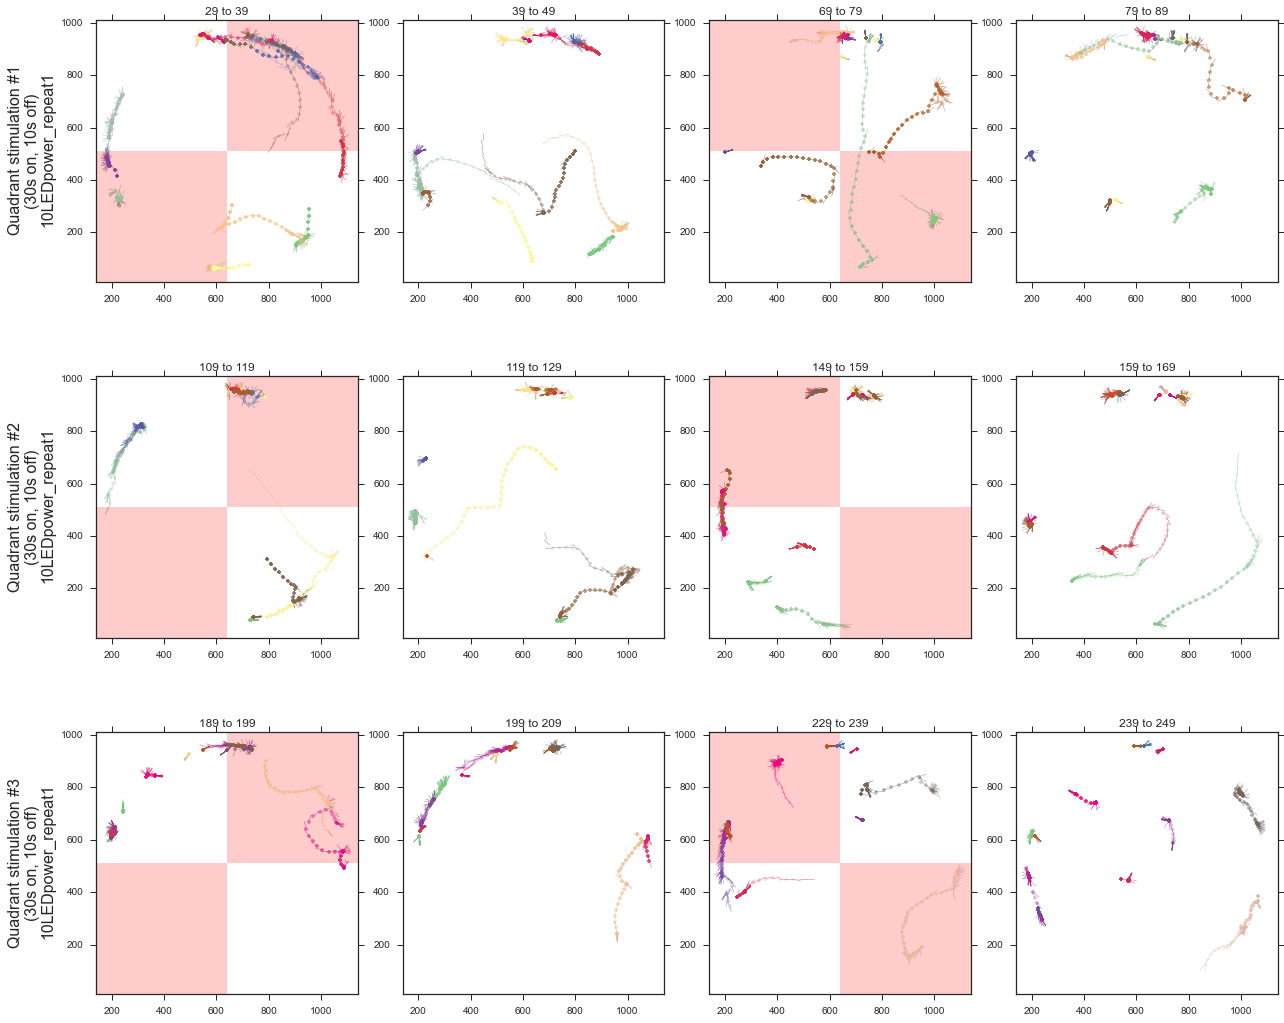

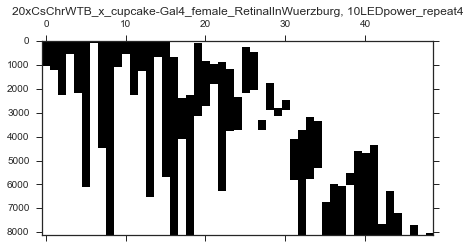

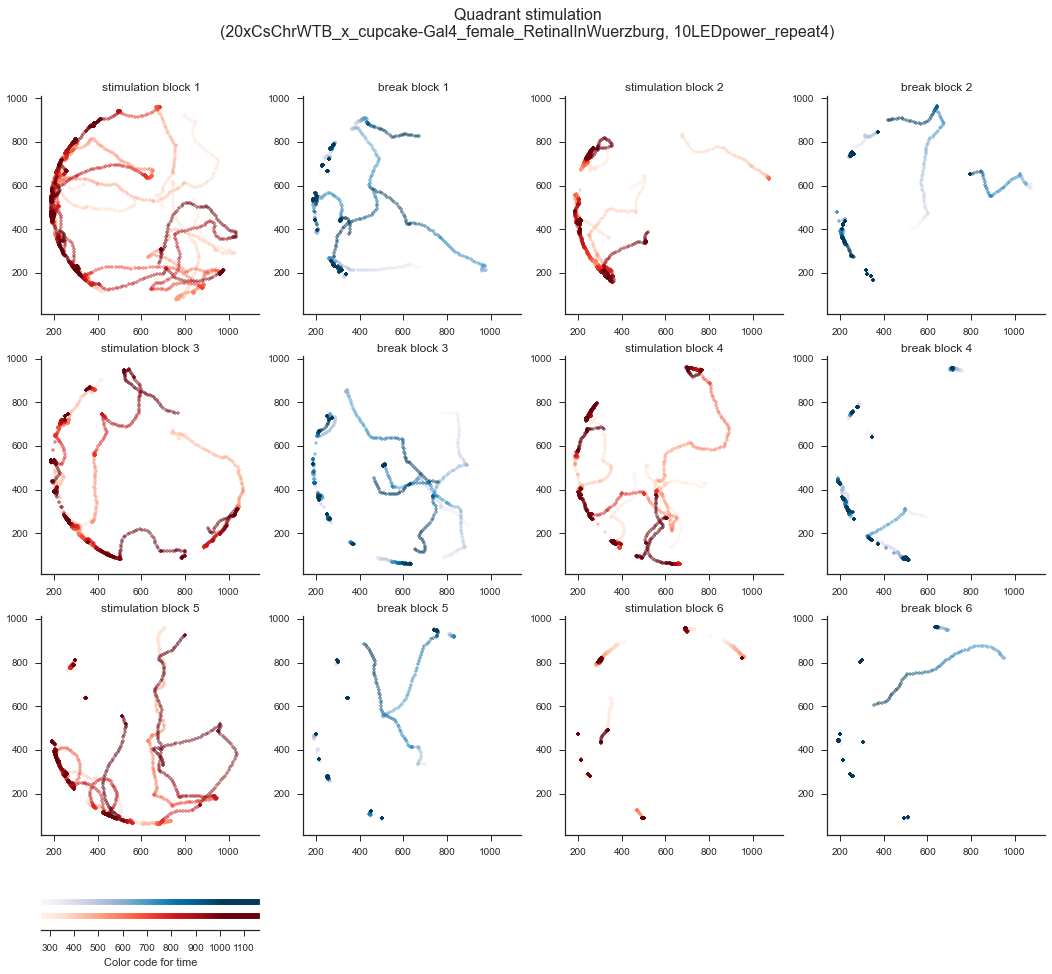

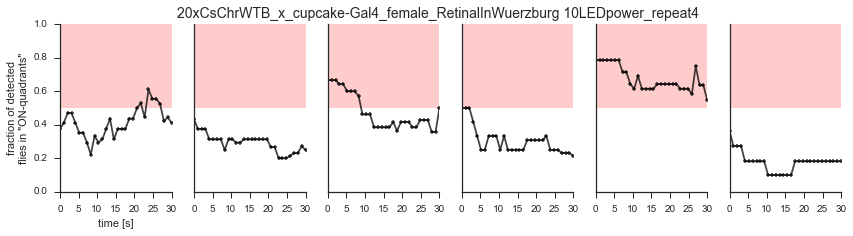

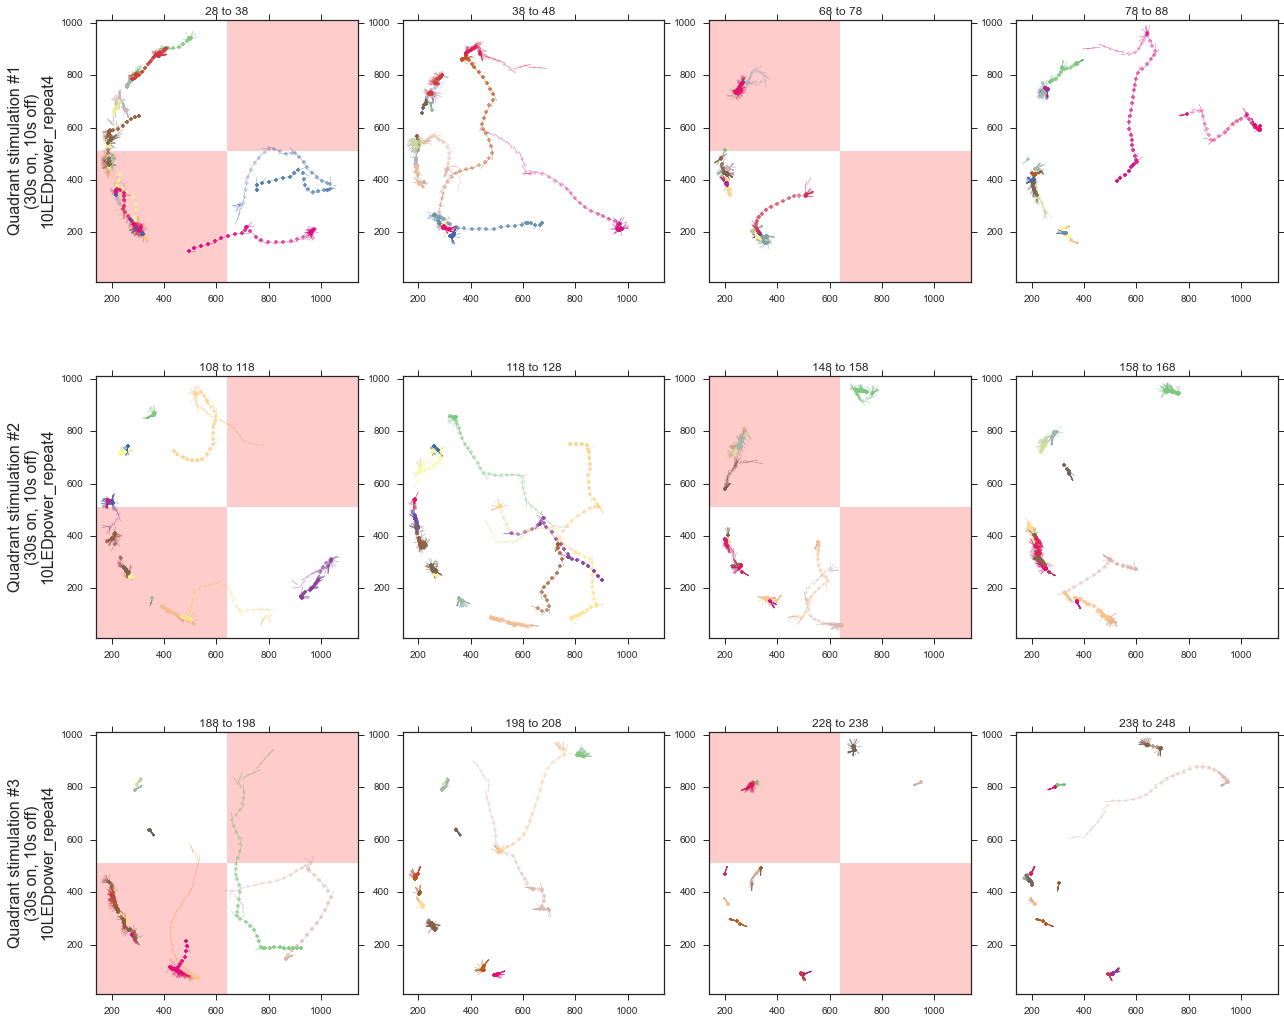

In [24]:
for repeat in range(1,6):
    stimStartFrameQ = int(startFrames[repeat-1])
    fileName = fileNames[repeat-1]

    # Quadrant stimulation
    stimSecQ = 30
    pauseSecQ = 10
    numRepeatQ = 3 # repeats x 2 patterns

    # Continuous full-field stimulation
    stimSecC = 1
    pauseSecC = 29
    numRepeatC = 1
    stimStartFrameC = stimStartFrameQ + fps * 2 * numRepeatQ * (stimSecQ + pauseSecQ)  # NOT VERY PRECISE!

    pixel2mm = 900/225 # Only estimated, NEED TO MEASURE THIS

    #---------------------------------------
    fileNameParts = fileName.split('_')

    genotype = '_'.join(fileNameParts[0:fileNameParts.index('cam')-2])
    experiment =  '_'.join(fileNameParts[5:7])
    expName = '(' + genotype + ', ' + experiment + ')'

    print(genotype)
    print(experiment)

    plotSaveDir = analysisDir + '/' + genotype + '_' + experiment + '_plots'

    try:
        mkdir(plotSaveDir)
    except OSError:
        print('Experiment folder already exists')

    #---------------------------------------
    # Define masks (for the moment assume that arena is perfectly centered and 
    # that quadrants are squares. Need to read in image frame and extract shapes by using edges.)
    LEDon = np.ones((imageSizePx[0]/2,imageSizePx[1]/2))
    LEDoff = np.zeros((imageSizePx[0]/2,imageSizePx[1]/2))

    # first stimulation pattern
    patternA = np.hstack((np.vstack((LEDon,LEDoff)),np.vstack((LEDoff,LEDon))))

    # second stimulation pattern
    patternB = np.hstack((np.vstack((LEDoff,LEDon)),np.vstack((LEDon,LEDoff))))

    #patternFig = plt.figure()
    #ax1 = patternFig.add_subplot(121); plt.spy(patternA); ax1.set_title('pattern A\n')
    #ax2 = patternFig.add_subplot(122); plt.spy(patternB); ax2.set_title('pattern B\n')


    #---------------------------------------
    ### Import and rearrange data
    #---------------------------------------

    keyList = ['timestamps','x_pos','y_pos','ntargets','identity','angle'] #data columns to be extracted from ctrax file

    try:
        #load existing python file
        npzData = np.load(baseDir + fileName + '.npz')
        xPos = npzData['xPos']
        yPos = npzData['yPos']
        angle = npzData['angle']
        flyID = npzData['flyID']
        numFrames = len(xPos)
        maxFlyID = max(flyID)

    except:
        #load matlab data and convert
        indat = loadmat(baseDir + fileName + '.mat')

        dat = [indat[k] for k in keyList]

        # Reorganise fly position arrays into lists (sorted by frame)
        numFrames = len(dat[0])
        xPos = []
        yPos = []
        angle = []
        flyID = []

        pointer = 0
        for t in range(numFrames):
            numFlies = dat[3][t].astype('int')[0]

            xPos.append(dat[1][pointer:pointer+numFlies])
            yPos.append(dat[2][pointer:pointer+numFlies])
            angle.append(dat[5][pointer:pointer+numFlies])
            flyID.append(dat[4][pointer:pointer+numFlies])

            pointer += numFlies

        xPos = np.array(xPos)
        yPos = np.array(yPos)
        angle = np.array(angle)
        flyID = np.array(flyID)
        maxFlyID = max(dat[4])

        #save data for future sessions
        np.savez(baseDir + '/' + fileName + '.npz', 
                 xPos=xPos, yPos=yPos, angle=angle, flyID=flyID,maxFlyID=maxFlyID)

    #---------------------------------------
    ### Visualise tracking performance
    #---------------------------------------

    # Reorganise fly track fragments into matrix (frame x fly id )
    flyIDperFrame = np.zeros((numFrames,maxFlyID+1))
    for frame in range(numFrames):
        fliesInFrame = np.array(flyID[frame]).squeeze().astype('int')
        if fliesInFrame.size == 1:
            flyIDperFrame[frame][fliesInFrame] = 1
        elif fliesInFrame.size > 1:
            for idx in fliesInFrame:
                flyIDperFrame[frame][idx] = 1

    #visualise resluting matrix
    fig = plotSparseMatrix((7,5),0.003,flyIDperFrame, genotype + ', ' + experiment + '\n')

    fig.savefig(plotSaveDir + '/' + fileName + '_traceFragments.pdf', format = 'pdf')

    #---------------------------------------
    ### Plot traces for each stimulation block (colour-coded time)
    #---------------------------------------

    #set frameBlocks
    skipFramesOFF = 3
    skipFramesON = 3

    def makeBeginIndexMatrix(stimStartFrame,numRepeat,stimS,pauseS):
        beginChr = np.array([[stimStartFrame + (repeat*stimS + repeat*pauseS) * fps, stimStartFrame + ((repeat+1)*stimS + repeat*pauseS) * fps]
                             for repeat in range(numRepeat)])
        return beginChr

    def makeEndIndexMatrix(stimStartFrame,numRepeat,stimS,pauseS):
        endChr = np.array([(stimStartFrame + ((repeat+1)*stimS + repeat*pauseS) * fps, stimStartFrame + ((repeat+1)*stimS + (repeat+1)*pauseS) * fps) 
                           for repeat in range(numRepeat)])
        return endChr

    #quadrant protocol
    beginChrQuadrant = makeBeginIndexMatrix(stimStartFrameQ,2*numRepeatQ,stimSecQ,pauseSecQ)
    endChrQuadrant = makeEndIndexMatrix(stimStartFrameQ,2*numRepeatQ,stimSecQ,pauseSecQ)
    framesToSkip = np.array([[skipFramesON,skipFramesOFF] for repeat in range(2*numRepeatQ)]) #repeat = 0...2*numRepeatQ-1

    chrQuadrantColor = np.array([['Reds','PuBu'] for repeat in range(2*numRepeatQ)]).ravel()
    chrQuadrant = np.vstack((beginChrQuadrant.ravel(),endChrQuadrant.ravel(),framesToSkip.ravel())).T

    #continuous protocol
    beginChrContinuous = makeBeginIndexMatrix(stimStartFrameC,numRepeatC,stimSecC,pauseSecC)
    endChrContinuous = makeEndIndexMatrix(stimStartFrameC,numRepeatC,stimSecC,pauseSecC)
    framesToSkip = np.array([[skipFramesON,skipFramesOFF] for repeat in range(numRepeatC)])

    chrContinuousColor = np.array([['Reds','PuBu'] for repeat in range(numRepeatC)]).ravel()
    chrContinuous = np.vstack((beginChrContinuous.ravel(),endChrContinuous.ravel(),framesToSkip.ravel())).T

    figQ = plotStimulationBlock_timeBar(chrQuadrant,chrQuadrantColor,
                                        'Quadrant stimulation\n' + expName,(18,15),numRepeatQ,imageSizePx)
    figQ.savefig(plotSaveDir + '/' + fileName + '_quadrantTrace.pdf', format = 'pdf')


    #---------------------------------------
    ### Fraction of flies in illuminated quadrants
    #---------------------------------------

    quadFractionFig = plt.figure(figsize=(14,3))
    numQuadRepeat = numRepeatQ*2

    for quadrantRepeat in range(numQuadRepeat):

        startFrame = stimStartFrameQ + quadrantRepeat*(stimSecQ+pauseSecQ)*fps

        if(quadrantRepeat%2 == 0): ONpattern = patternA
        else: ONpattern = patternB

        frameRange = range(startFrame,startFrame + stimSecQ*fps,30)
        time = np.linspace(0,stimSecQ,len(frameRange))

        fliesInLEDon = np.empty((len(frameRange),1))
        fractionInLEDon = np.empty((len(frameRange),1))

        for ind, frame in enumerate(frameRange):
            try:
                #assemble fly positions for frame
                spsData = np.ones((len(xPos[frame]),1)).squeeze()
                spsRowInds = np.array(xPos[frame].astype('int').squeeze())
                spsColInds = np.array(yPos[frame].astype('int').squeeze())

                flyLocations = sps.coo_matrix((spsData, (spsRowInds, spsColInds)), 
                                              shape=(imageSizePx[0],imageSizePx[1])).toarray()

                #check in wich pattern flies appear
                fliesInONpattern = (ONpattern + flyLocations)>1
                fliesInLEDon[ind] = sum(sum(fliesInONpattern))
                fractionInLEDon[ind] = sum(sum(fliesInONpattern))/sum(sum(flyLocations))

            except IndexError:
                print('movie too short')
                break

        subplt = quadFractionFig.add_subplot(1,numQuadRepeat,quadrantRepeat+1)
        subplt.plot(time,fractionInLEDon, marker = '.', linestyle = '-', color = 'black',alpha = 0.75)
        lightONindicator(subplt,0, 0.5, stimSecQ, 0.5)

        sns.despine(right=True,offset = 0)#trim=True)
        sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

        subplt.set_ylim((0,1)) 
        if(quadrantRepeat==0):
            subplt.set_xlabel('time [s]')
            subplt.set_ylabel('fraction of detected\nflies in "ON-quadrants"')
        else:
            subplt.set_yticks([])

    quadFractionFig.suptitle(genotype + ' ' + experiment + '\n', fontsize = 14)
    quadFractionFig.savefig(plotSaveDir + '/' + fileName + '_fractionInLEDon.pdf', format = 'pdf')


    #---------------------------------------
    ### Detailed traces during the quadrant trials
    #---------------------------------------

    def addQuadrantLightIndicator(indicatorSubPlt, imageSizePx, quadPattern):
        if quadPattern == 0:
            lightONindicator(indicatorSubPlt, 0, 0, imageSizePx[0]/2, imageSizePx[1]/2)
            lightONindicator(indicatorSubPlt, imageSizePx[0]/2, imageSizePx[1]/2, imageSizePx[0]/2, imageSizePx[1]/2)
        else:
            lightONindicator(indicatorSubPlt, 0, imageSizePx[1]/2, imageSizePx[0]/2, imageSizePx[1]/2)
            lightONindicator(indicatorSubPlt, imageSizePx[0]/2, 0, imageSizePx[0]/2, imageSizePx[1]/2)

    timeWindow = 10
    figSize = (18,15)
    skipFrames = 6
    fig = plt.figure(figsize = figSize);

    strtFrame = stimStartFrameQ
    for quadrantRepeat in range(0,numRepeatQ): #Quadrant Repeats

        for pat in range(2):
            #End of quadrant stimulation
            activeFragments_pre,fRange,titleString = defineQuadrantDetail(strtFrame,stimSecQ,timeWindow,fps,flyIDperFrame,skipFrames,'pre')

            subplt1 = fig.add_subplot(numRepeatQ, 4, 1 + pat*2 + quadrantRepeat*4)
            plotActiveSegments(activeFragments_pre,fRange,subplt1,titleString,xPos,yPos,angle,flyID,imageSizePx)

            #After quadrant stimulation
            activeFragments_post,fRange,titleString = defineQuadrantDetail(strtFrame,stimSecQ,timeWindow,fps,flyIDperFrame,skipFrames,'post')

            subplt2 = fig.add_subplot(numRepeatQ, 4, 2 + pat*2 + quadrantRepeat*4)
            plotActiveSegments(activeFragments_post,fRange,subplt2,titleString,xPos,yPos,angle,flyID,imageSizePx)

            #Add light ON indicators
            if (not pat):
                subplt1.set_ylabel('Quadrant stimulation #'+ str(quadrantRepeat+1) +
                                   '\n('+str(stimSecQ)+'s on, '+str(pauseSecQ)+'s off)\n' + experiment,fontsize = 16)

            addQuadrantLightIndicator(subplt1, imageSizePx, pat)

            #update start frame
            strtFrame = strtFrame + (stimSecQ+pauseSecQ)*fps

    fig.tight_layout()
    fig.savefig(plotSaveDir + '/' + fileName + '_detail.pdf', format = 'pdf')

    #---------------------------------------

    #---------------------------------------

In [31]:
ledpow = 'LED10'
baseDir = '/Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/\
20xCsChrWTB_x_cupcake_female_RetinalInWuerzburg/group/'+ledpow+'/'

numRep = 6

analysisDir = baseDir

expListFile = baseDir + 'firstFrames.csv'
print('Reading in stimulation start frame list from ' + expListFile)

# load file specifying data to be analysed
fileList = open(expListFile, 'r')
csv_fileList = reader(fileList)

# get header
header = fileList.readline().split(',')

fileNames = []
startFrames = []

for line in csv_fileList:
    fileNames.append(line[1])
    startFrames.append(line[2])

numQuadRepeat = numRepeatQ*2
windowSize = 30

fractionInLEDonAll = np.zeros((numRep, numQuadRepeat, windowSize))
time = np.linspace(0,stimSecQ,windowSize)

genotype = baseDir.split('/')[-4]

plotSaveDir = analysisDir + '/' + genotype + '_' + ledpow + '_plots'
print(genotype)

try:
    mkdir(plotSaveDir)
except OSError:
    print('Experiment folder already exists')

for repeat in range(1,numRep+1):
    print(repeat)
    stimStartFrameQ = int(startFrames[repeat-1])
    fileName = fileNames[repeat-1]

    # Quadrant stimulation
    stimSecQ = 30
    pauseSecQ = 10
    numRepeatQ = 3 # repeats x 2 patterns

    # Continuous full-field stimulation
    stimSecC = 1
    pauseSecC = 29
    numRepeatC = 1
    stimStartFrameC = stimStartFrameQ + fps * 2 * numRepeatQ * (stimSecQ + pauseSecQ)  # NOT VERY PRECISE!

    pixel2mm = 900/225 # Only estimated, NEED TO MEASURE THIS

    #---------------------------------------
    # Define masks (for the moment assume that arena is perfectly centered and 
    # that quadrants are squares. Need to read in image frame and extract shapes by using edges.)
    LEDon = np.ones((imageSizePx[0]/2,imageSizePx[1]/2))
    LEDoff = np.zeros((imageSizePx[0]/2,imageSizePx[1]/2))

    # first stimulation pattern
    patternA = np.hstack((np.vstack((LEDon,LEDoff)),np.vstack((LEDoff,LEDon))))

    # second stimulation pattern
    patternB = np.hstack((np.vstack((LEDoff,LEDon)),np.vstack((LEDon,LEDoff))))

    #---------------------------------------
    ### Import data
    #---------------------------------------

    indat = loadmat(baseDir + fileName + '.mat')

    dat = [indat[k] for k in keyList]

    # Reorganise fly position arrays into lists (sorted by frame)
    numFrames = len(dat[0])
    xPos = []
    yPos = []
    angle = []
    flyID = []

    pointer = 0
    for t in range(numFrames):
        numFlies = dat[3][t].astype('int')[0]

        xPos.append(dat[1][pointer:pointer+numFlies])
        yPos.append(dat[2][pointer:pointer+numFlies])
        angle.append(dat[5][pointer:pointer+numFlies])
        flyID.append(dat[4][pointer:pointer+numFlies])

        pointer += numFlies

    xPos = np.array(xPos)
    yPos = np.array(yPos)
    angle = np.array(angle)
    flyID = np.array(flyID)
    maxFlyID = max(dat[4])
 
    #---------------------------------------
    ### Fraction of flies in illuminated quadrants
    #---------------------------------------
    for quadrantRepeat in range(numQuadRepeat):

        startFrame = stimStartFrameQ + quadrantRepeat*(stimSecQ+pauseSecQ)*fps

        if(quadrantRepeat%2 == 0): ONpattern = patternA
        else: ONpattern = patternB

        frameRange = range(startFrame,startFrame + stimSecQ*fps,windowSize)

        fliesInLEDon = np.empty((len(frameRange),1))
        fractionInLEDon = np.empty((len(frameRange),1))

        for ind, frame in enumerate(frameRange):
            try:
                #assemble fly positions for frame
                spsData = np.ones((len(xPos[frame]),1)).squeeze()
                spsRowInds = np.array(xPos[frame].astype('int').squeeze())
                spsColInds = np.array(yPos[frame].astype('int').squeeze())

                flyLocations = sps.coo_matrix((spsData, (spsRowInds, spsColInds)), 
                                              shape=(imageSizePx[0],imageSizePx[1])).toarray()

                #check in wich pattern flies appear
                fliesInONpattern = (ONpattern + flyLocations)>1
                fliesInLEDon[ind] = sum(sum(fliesInONpattern))
                fractionInLEDon[ind] = sum(sum(fliesInONpattern))/sum(sum(flyLocations))

            except IndexError:
                print('movie too short')
                break

        fractionInLEDonAll[repeat-1,quadrantRepeat,:] = np.squeeze(fractionInLEDon)

Reading in stimulation start frame list from /Volumes/jayaramanlab/Hannah/Projects/OptogeneticsFreeWalkingArena/1_Data/virtualReinforcement/20xCsChrWTB_x_cupcake_female_RetinalInWuerzburg/group/LED10/firstFrames.csv
20xCsChrWTB_x_cupcake_female_RetinalInWuerzburg
1
2
3
4
5
6


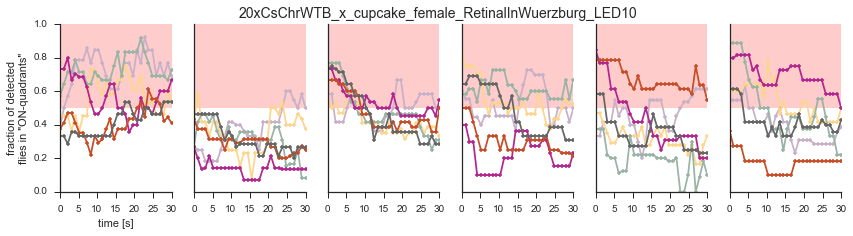

In [32]:
#---------------------------------------

import matplotlib.colors as colors
import matplotlib.cm as cmx

cNorm  = colors.Normalize(vmin=0, vmax=numRep)
repMap = cmx.ScalarMappable(norm=cNorm, cmap='Accent')

quadFractionFig = plt.figure(figsize=(14,3))

for quadrantRepeat in range(numQuadRepeat):

    if(quadrantRepeat%2 == 0): ONpattern = patternA
    else: ONpattern = patternB

    subplt = quadFractionFig.add_subplot(1,numQuadRepeat,quadrantRepeat+1)
    lightONindicator(subplt,0, 0.5, stimSecQ, 0.5)

    sns.despine(right=True,offset = 0)#trim=True)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

    subplt.set_ylim((0,1)) 
    if(quadrantRepeat==0):
        subplt.set_xlabel('time [s]')
        subplt.set_ylabel('fraction of detected\nflies in "ON-quadrants"')
    else:
        subplt.set_yticks([])

for repeat in range(1,numRep+1):

    for quadrantRepeat in range(numQuadRepeat):

        if(quadrantRepeat%2 == 0): ONpattern = patternA
        else: ONpattern = patternB

        subplt = quadFractionFig.add_subplot(1,numQuadRepeat,quadrantRepeat+1)
        subplt.plot(time,fractionInLEDonAll[repeat-1,quadrantRepeat,:], marker = '.', 
                    linestyle = '-', color = repMap.to_rgba(repeat),alpha=1)
        

quadFractionFig.suptitle(genotype + '_' + ledpow +'\n', fontsize = 14)
quadFractionFig.savefig(plotSaveDir + '/' + genotype + '_' + ledpow + '_fractionInLEDon.pdf', format = 'pdf')

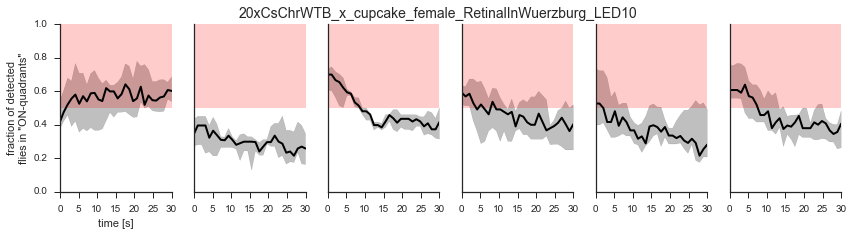

In [33]:
quadFractionFig = plt.figure(figsize=(14,3))

for quadrantRepeat in range(numQuadRepeat):

    if(quadrantRepeat%2 == 0): ONpattern = patternA
    else: ONpattern = patternB

    subplt = quadFractionFig.add_subplot(1,numQuadRepeat,quadrantRepeat+1)
    lightONindicator(subplt,0, 0.5, stimSecQ, 0.5)

    sns.despine(right=True,offset = 0)#trim=True)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

    subplt.set_ylim((0,1)) 
    if(quadrantRepeat==0):
        subplt.set_xlabel('time [s]')
        subplt.set_ylabel('fraction of detected\nflies in "ON-quadrants"')
    else:
        subplt.set_yticks([])

    if(quadrantRepeat%2 == 0): ONpattern = patternA
    else: ONpattern = patternB
    
    meanResp = np.median(fractionInLEDonAll[:,quadrantRepeat,:],0).transpose()
    q75, q25 = np.percentile(fractionInLEDonAll[:,quadrantRepeat,:], [75 ,25], axis=0)

    subplt = quadFractionFig.add_subplot(1,numQuadRepeat,quadrantRepeat+1)
    subplt.plot(time,meanResp, linestyle = '-', color = 'black',alpha=1, linewidth=2)
    subplt.fill_between(time, q25, q75, color='black', alpha=0.25)
    

quadFractionFig.suptitle(genotype + '_' + ledpow +'\n', fontsize = 14)
quadFractionFig.savefig(plotSaveDir + '/' + genotype + '_' + ledpow + '_fractionInLEDon_median.pdf', format = 'pdf')

###Function definitions (in order of apprearance)

In [8]:
def plotSparseMatrix(figsize,aspectRatio,matrixToPlot,titleString):
    fig = plt.figure(figsize = figsize)
    fig.set_canvas(plt.gcf().canvas)
    sns.set_style('ticks')
    ax = fig.add_subplot(111)
    
    ax.spy(matrixToPlot)
    ax.set_aspect(aspectRatio)
    ax.set_title(titleString)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})
    
    return fig

In [9]:
def plotPosInRange(ax,frameRange,xPos,yPos,currCmap,imageSizePx):
    cNorm  = colors.Normalize(vmin=0, vmax=2.5*len(frameRange))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    
    for frame in frameRange:
        try:
            ax.plot(xPos[frame],yPos[frame],marker='.',linestyle='none',alpha=0.5, 
                    color=scalarMap.to_rgba(frame-frameRange[0]))
        except IndexError:
            print('movie too short')
            break
    
    ax.set_aspect('equal')
    sns.despine(right=True,offset = 0)#trim=True)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})
    
    plt.xlim([imageSizePx[0]/2.0 - 500,imageSizePx[0]/2.0 + 500]);
    plt.ylim([imageSizePx[1]/2.0 - 500,imageSizePx[1]/2.0 + 500]);

In [10]:
def plotStimulationBlock(fig,figGridSpace,blockFrames,blockColors,colNumber,rowNumber,imageSizePx):
    
    for block in range(len(blockFrames)):
        frames = range(blockFrames[block][0],blockFrames[block][1],blockFrames[block][2])
        subplt = fig.add_subplot(figGridSpace[block])
        plotPosInRange(subplt,frames,xPos,yPos,blockColors[block],imageSizePx)
        if(block%2):#odd
            subplt.set_title('break block ' + str(block/2 + 1))
        else:
            subplt.set_title('stimulation block ' + str(block/2 + 1))

    return fig

In [11]:
def defineQuadrantDetail(strtFrame, stimSecQ, timeWindow, fps, flyIDperFrame, skipFrames, windowType):

    if windowType == 'pre':
        fRange = range(strtFrame + (stimSecQ-timeWindow)*fps, strtFrame + stimSecQ*fps,skipFrames)
        titleString = str(strtFrame/fps + (stimSecQ-timeWindow)) + ' to ' + str(strtFrame/fps + stimSecQ)
    elif windowType == 'post':
        fRange = range(strtFrame + stimSecQ*fps, strtFrame + (stimSecQ+timeWindow)*fps,skipFrames)
        titleString = str(strtFrame/fps + stimSecQ) + ' to ' + str(strtFrame/fps + (stimSecQ+timeWindow))
    else:
        print('Invalid window type')
        return

    try:
        activeFragments = np.array(np.nonzero(sum(flyIDperFrame[fRange]))).squeeze()
    except IndexError:
        print('movie too short')
        activeFragments = np.empty((1,1))

    return activeFragments, fRange, titleString

In [12]:
def plotStimulationBlock_timeBar(blockFrames,blockColors,title,figureSize,colNumber,imageSizePx):
    
    blockfig = plt.figure(figsize = figureSize)
    blockfig.set_canvas(plt.gcf().canvas)
    sns.set_style('ticks')
    blockfig.suptitle(title,fontsize = 16)
    
    rowNumber = len(blockFrames)/colNumber
    gs = gridspec.GridSpec(colNumber+1,rowNumber, height_ratios=np.hstack((np.repeat(4,colNumber),1))) 
    blockfig = plotStimulationBlock(blockfig,gs,blockFrames,blockColors,colNumber+1,rowNumber,imageSizePx)
        
    #time color code
    timeplt = blockfig.add_subplot(gs[len(blockFrames):len(blockFrames)+1])
    frameRange = range(blockFrames[0][0],blockFrames[0][1],blockFrames[0][2])
    cNorm  = colors.Normalize(vmin=0, vmax=2.5*len(frameRange))
        
    for col in range(2):
        for frame in frameRange:
            scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=blockColors[col])
            timeplt.plot(frame,0.5*col+1 ,marker='.',markersize=12,linestyle='none',alpha=0.5,
                         color=scalarMap.to_rgba(frame-frameRange[0])) 
    
    timeplt.get_xaxis().tick_bottom()
    timeplt.get_yaxis().set_visible(False)
    timeplt.spines['top'].set_visible(False)
    timeplt.spines['right'].set_visible(False)
    timeplt.spines['left'].set_visible(False)
    plt.xlim([frameRange[0],frameRange[-1]]);
    plt.ylim([0.5,2.5]);
    plt.xlabel('Color code for time')
    
    return blockfig

In [13]:
def lightONindicator(subplt,x,y,width,height):
    subplt.add_patch(
        patches.Rectangle(
             (x,y), width, height,
            alpha = 0.2, facecolor = 'red', edgecolor = 'none'
        )
    )

In [14]:
def plotActiveSegments(activeFragments,frameRange,subplt,titleString,xPos,yPos,angle,flyID,imageSizePx):
    if(sum(activeFragments).squeeze() == 0):
        return
    
    flyRange = range(min(activeFragments),max(activeFragments)+1)

    cNorm  = colors.Normalize(vmin=min(activeFragments), vmax=max(activeFragments+1))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

    arrowScale = 5
    
    for currFly in flyRange:
        counter = 0.0
        for frame in frameRange:
            currX = xPos[frame][flyID[frame] == currFly]
            currY = yPos[frame][flyID[frame] == currFly]
            
            try:
                newArrow = patches.Arrow(currX.squeeze(), currY.squeeze(), np.cos(angle[frame][flyID[frame] == currFly]).squeeze()*30,
                                         np.sin(angle[frame][flyID[frame] == currFly]).squeeze()*30, width=2,
                                         edgecolor = scalarMap.to_rgba(currFly),alpha = 0.5)
                subplt.add_patch(newArrow)
            except:
                continue
                
            subplt.plot(currX,currY, marker='.',color=scalarMap.to_rgba(currFly), markersize=8,
                        alpha = 1-counter/(len(frameRange)))
            
            counter +=1.0
    subplt.set_aspect('equal')
    subplt.set_title(titleString) 
    
    plt.xlim([imageSizePx[0]/2 - 500,imageSizePx[0]/2 + 500]);
    plt.ylim([imageSizePx[1]/2 - 500,imageSizePx[1]/2 + 500]);
    
    return